In [1]:
import os
import json
import numpy as np
from dateutil import parser
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import deepcopy
from pymongo import MongoClient
from packaging.version import Version
from multipy.fwer import holm_bonferroni

%matplotlib inline
%config InlineBackend.figure_format="retina"
pd.set_option("display.max_rows", None)

In [2]:
pypi_db = MongoClient(host="127.0.0.1", port=27017)['pypi']
dist_meta = pypi_db['distribution_metadata']
dl_sc = pypi_db['dl_packages']
pkg_layers = pd.read_csv("data/package_statistics.csv")
versioned_df = pd.DataFrame(list(dl_sc.find({}, projection={"_id": 0})))
frameworks = {
    "tensorflow": ['tensorflow', 'tensorflow-cpu', 'tensorflow-gpu'],
    "pytorch": ['torch'],
    "mxnet": ['mxnet', 'mxnet-cu112', 'mxnet-cu110', 'mxnet-cu102', 'mxnet-cu102mkl', 'mxnet-cu101', 'mxnet-cu101mkl', 
              'mxnet-cu100', 'mxnet-cu100mkl', 'mxnet-cu92', 'mxnet-cu92mkl', 'mxnet-cu90', 'mxnet-cu90mkl', 
              'mxnet-cu80', 'mxnet-cu80mkl', 'mxnet-native'],
    "paddlepaddle": ['paddlepaddle', 'paddlepaddle-gpu'],
    "mindspore": ['mindspore', 'mindspore-ascend', 'mindspore-gpu']
}

In [3]:
def check_version(v) -> bool:
    try:
        v = Version(v)
        return v.is_prerelease or v.is_devrelease
    except:
        return True


def retrieve_ordered_versions(pkg: str) -> list:
    res = list(dist_meta.find({"name": pkg}, projection={"_id": 0, "version": 1, "upload_time": 1}))
    res = pd.DataFrame(res)
    res = res.groupby("version")['upload_time'].min().sort_values()
    return {v: parser.parse(res[v]).timestamp() for v in list(res.index) if not check_version(v)}

def retrieve_all_pkg_versions():
    pkgs = list(pkg_layers['package'].unique())
    all_versions = dict()
    for p in pkgs:
        all_versions[p] = retrieve_ordered_versions(p)
    return all_versions

def retrieve_sc_versions(pkg: str, frmwk: str) -> list:
    pipeline = [
        {
            '$match': {
                'name': pkg, 
                'framework': frmwk
            }
        }, {
            '$group': {
                '_id': None, 
                'versions': {
                    '$addToSet': '$version'
                }
            }
        }
    ]
    res = pd.DataFrame(list(dl_sc.aggregate(pipeline)))
    return [v for v in res.loc[0, 'versions'] if not check_version(v)]


In [4]:
if not os.path.exists("data/pkg_version_time.json"):
    pkg_ver_time = retrieve_all_pkg_versions()
    with open("data/pkg_version_time.json", "w") as outf:
        json.dump(pkg_ver_time, outf)
else:
    pkg_ver_time = json.load(open("data/pkg_version_time.json"))

In [5]:
def support_version_ratio(pkg: str, frmwk: str):
    return len(retrieve_sc_versions(pkg, frmwk)) / len(pkg_ver_time[pkg])

def technical_time_lag(pkg: str, frmwk: str):
    ordered_versions = pkg_ver_time[pkg]
    ts_delta = max(ordered_versions.values()) - max([ordered_versions[_] for _ in retrieve_sc_versions(pkg, frmwk)])
    return ts_delta / 86400

def version_distance(pkg: str, frmwk1: str, frmwk2: str):
    all_vers = retrieve_ordered_versions(pkg)
    vers1 = retrieve_sc_versions(pkg, frmwk1)
    vers2 = retrieve_sc_versions(pkg, frmwk2)
    idx1 = [all_vers.index(_) for _ in vers1]
    idx2 = [all_vers.index(_) for _ in vers2]
    idx1.sort()
    idx2.sort()
    
    def distance1(idx1, idx2):
        l = min(len(idx1), len(idx2))
        return np.mean(idx1[-l: ]) - np.mean(idx2[-l: ])
    
    def distance2(idx1, idx2):
        res = 0
        if idx1[-1] == idx2[-1]:
            res = 0
        elif idx1[-1] < idx2[-1]:
            for i in range(len(idx2)):
                if idx2[-1-i] > idx1[-1]:
                    res -=1
        else:
            for i in range(len(idx1)):
                if idx1[-1-i] > idx2[-1]:
                    res += 1
        return res
    
    return distance2(idx1, idx2)


## Version Analysis

In [6]:
def support_ratio_framework(frmwk: str):
    res = dict()
    pkgs = list(pkg_layers[pkg_layers['framework'] == frmwk]['package'].unique())
    for p in pkgs:
        res[p] = support_version_ratio(p, frmwk)
    return res

def support_ratio_all_frameworks(frmwks: list):
    res = dict()
    for f in frmwks:
        res[f] = support_ratio_framework(f)
    return res

sup_ver_ratios = support_ratio_all_frameworks(['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle', 'mindspore'])

In [7]:
def time_lag_frameworks(frmwk: str):
    res = dict()
    pkgs = list(pkg_layers[pkg_layers['framework'] == frmwk]['package'].unique())
    for p in pkgs:
        l = technical_time_lag(p, frmwk)
        if l > 0:
            res[p] = l
    return res

def time_lag_all_framneworks(frmwks: list):
    res = dict()
    for f in frmwks:
        res[f] = time_lag_frameworks(f)
    return res

time_lags = time_lag_all_framneworks(['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle', 'mindspore'])

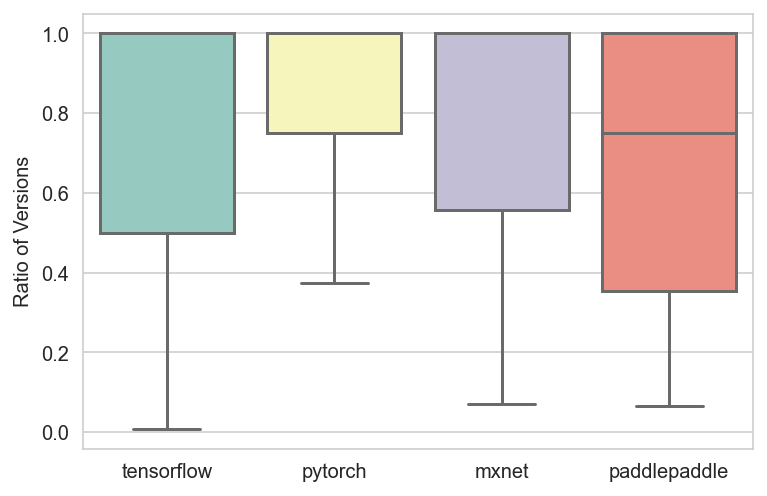

In [8]:
def support_ratio_boxplot(frmwks: str):
    sns.set_style("whitegrid")
    bp = sns.boxplot(data=[list(sup_ver_ratios[k].values()) for k in frmwks], palette="Set3", fliersize=1, showfliers=False)
    # print([item.get_ydata() for item in bp['whiskers']])
    bp.set_ylabel("Ratio of Versions")
    bp.set_xticklabels(frmwks)
    plt.savefig("figures/support_version_ratio.pdf", bbox_inches="tight")

support_ratio_boxplot(['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle'])

In [9]:
def sup_ver_ratio_comp(frmwk1: str, frmwk2: str, alter: str):
    r1 = list(sup_ver_ratios[frmwk1].values())
    r2 = list(sup_ver_ratios[frmwk2].values())
    return stats.mannwhitneyu(r1, r2, alternative=alter)
    
_, p1 = sup_ver_ratio_comp('tensorflow', 'pytorch', 'less')
_, p2 = sup_ver_ratio_comp('tensorflow', 'mxnet', 'two-sided')
_, p3 = sup_ver_ratio_comp('tensorflow', 'paddlepaddle', 'two-sided')
_, p4 = sup_ver_ratio_comp('pytorch', 'mxnet', 'greater')
_, p5 = sup_ver_ratio_comp('pytorch', 'paddlepaddle', 'greater')
_, p6 = sup_ver_ratio_comp('mxnet', 'paddlepaddle', 'two-sided')
print(p1, p2, p3, p4, p5, p6)
holm_bonferroni([p1, p2, p3, p4, p5, p6])

2.2297317059877873e-19 0.3955004951150596 0.21925633483652462 0.1274671905322815 0.0034034292357860868 0.13821118046291114


array([ True, False, False, False,  True, False])

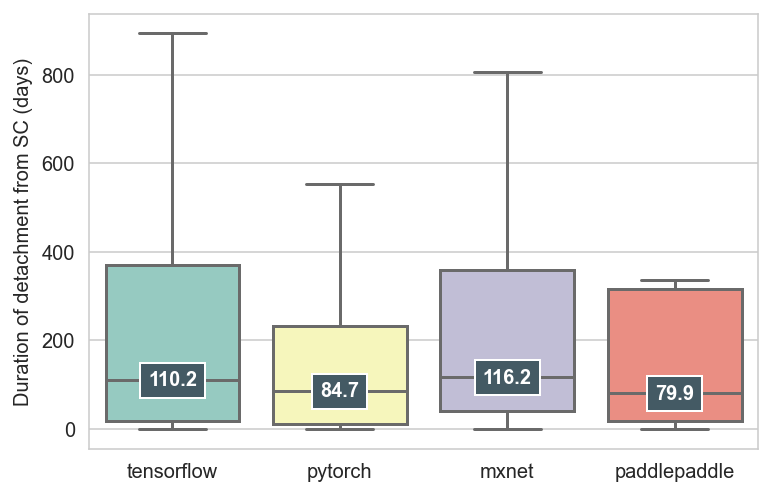

In [10]:
def time_lag_boxplot(frmwks: list):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots()
    data = []
    for k in frmwks:
        d = np.array(list(time_lags[k].values()))
        data.append(d)
    bp2 = sns.boxplot(data=data, palette="Set3", fliersize=1, showfliers = False)
    for xtick in bp2.get_xticks():
        m = np.median(list(data[xtick]))
        bp2.text(xtick, m, f'{m:.1f}', ha='center', va='center', fontweight='bold', size=10, color='white', bbox=dict(facecolor='#445A64'))
    # bp2.set_yscale("log")
    bp2.set_ylabel("Duration of detachment from SC (days)")
    bp2.set_xticklabels(frmwks)
    fig.savefig("figures/time_lag.pdf", bbox_inches='tight')

time_lag_boxplot(['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle'])

In [11]:
def sup_ver_ratio_comp(frmwk1: str, frmwk2: str, alter: str):
    r1 = list(time_lags[frmwk1].values())
    r2 = list(time_lags[frmwk2].values())
    return stats.mannwhitneyu(r1, r2, alternative=alter)
    
_, p1 = sup_ver_ratio_comp('tensorflow', 'pytorch', 'greater')
_, p2 = sup_ver_ratio_comp('tensorflow', 'mxnet', 'two-sided')
_, p3 = sup_ver_ratio_comp('tensorflow', 'paddlepaddle', 'two-sided')
_, p4 = sup_ver_ratio_comp('pytorch', 'mxnet', 'two-sided')
_, p5 = sup_ver_ratio_comp('pytorch', 'paddlepaddle', 'two-sided')
_, p6 = sup_ver_ratio_comp('mxnet', 'paddlepaddle', 'two-sided')
print(p1, p2, p3, p4, p5, p6)
holm_bonferroni([p1, p2, p3, p4, p5, p6])

0.0009227489222947367 0.6461502454591026 0.5919665976941177 0.19363927561171135 0.7914746514453581 0.4665891952838639


array([ True, False, False, False, False, False])

In [12]:
for f in ['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle']:
    a = np.array(list(sup_ver_ratios[f].values()))
    d = np.array(list(time_lags[f].values()))
    wo_full = np.sum(a < 1)
    with_latest = np.sum(a == 1) + np.sum(d == 0)
    print(f"{f}: {wo_full} of {len(a)} ({np.sum(a < 1) / len(a)*100:.2f}%) packages without full support, {with_latest} of {len(a)} ({with_latest / len(a)*100:.2f}%) packages with latest support")

tensorflow: 1225 of 2565 (47.76%) packages without full support, 1340 of 2565 (52.24%) packages with latest support
pytorch: 1244 of 3277 (37.96%) packages without full support, 2033 of 3277 (62.04%) packages with latest support
mxnet: 30 of 71 (42.25%) packages without full support, 41 of 71 (57.75%) packages with latest support
paddlepaddle: 18 of 31 (58.06%) packages without full support, 13 of 31 (41.94%) packages with latest support


In [13]:
def single_ver_sc(f: str, version: str):
    sc = {}
    frmwks = frameworks[f]
    sc[1] = set(frmwks)
    layer = 1
    right_df = pd.DataFrame()
    right_df.loc[:, 'name'] = frmwks
    right_df.loc[:, 'version'] = version
    all_df = pd.DataFrame()
    all_df = all_df.append(right_df)
    tmp_df = versioned_df[versioned_df['framework'] == f]
    while not right_df.empty:
        layer += 1
        tmp = tmp_df.merge(right_df, left_on=['dependency', 'dependency_version'], right_on=['name', 'version'])
        if not tmp.empty:
            sc[layer] = set(tmp['name_x'].unique())
            right_df = tmp[['name_x', 'version_x']].drop_duplicates().rename(columns={'name_x': 'name', 'version_x': 'version'})
            right_df = right_df[~(right_df['name'].isin(all_df['name']) & right_df['version'].isin(all_df['version']))]
            all_df = all_df.append(right_df)
            # print('layer: {} finished'.format(layer))
        else:
            break
    return sc

def version_sc(frmwks: list):
    res = {}
    for f in frmwks:
        res[f] = dict()
        if f == 'pytorch':
            vers = list(retrieve_ordered_versions('torch').keys())
        else:
            vers = list(retrieve_ordered_versions(f).keys())
        vers.sort(key=Version)
        for v in vers:
            res[f][v] = single_ver_sc(f, v)
        print('Finish', f)
    return res

In [14]:
ver_scs = version_sc(['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle', 'mindspore'])

Finish tensorflow
Finish pytorch
Finish mxnet
Finish paddlepaddle
Finish mindspore


In [15]:
ver_scs['tensorflow'].keys()

dict_keys(['0.12.0', '0.12.1', '1.0.0', '1.0.1', '1.1.0', '1.2.0', '1.2.1', '1.3.0', '1.4.0', '1.4.1', '1.5.0', '1.5.1', '1.6.0', '1.7.0', '1.7.1', '1.8.0', '1.9.0', '1.10.0', '1.10.1', '1.11.0', '1.12.0', '1.12.2', '1.12.3', '1.13.1', '1.13.2', '1.14.0', '1.15.0', '1.15.2', '1.15.3', '1.15.4', '1.15.5', '2.0.0', '2.0.1', '2.0.2', '2.0.3', '2.0.4', '2.1.0', '2.1.1', '2.1.2', '2.1.3', '2.1.4', '2.2.0', '2.2.1', '2.2.2', '2.2.3', '2.3.0', '2.3.1', '2.3.2', '2.3.3', '2.3.4', '2.4.0', '2.4.1', '2.4.2', '2.4.3', '2.4.4', '2.5.0', '2.5.1', '2.5.2', '2.6.0', '2.6.1', '2.6.2', '2.7.0'])

In [16]:
def add_rmv_over_version(frmwks: list):
    res = pd.DataFrame()
    for f in frmwks:
        prior = set()
        index = 0
        labels = list(ver_scs[f].keys())
        for ver, sc in ver_scs[f].items():
            if index == 0:
                for l, p in sc.items():
                    prior = prior.union(p)
            else:
                pkgs = set()
                for l, p in sc.items():
                    pkgs = pkgs.union(p)
                
                res = res.append([{'Addition': len(pkgs - prior), 'Removal': len(prior - pkgs), 
                                   'Version': labels[index], 'Framework': f}], 
                                 ignore_index=True)
                prior = pkgs
            index += 1
    return res

In [17]:
add_rmv = add_rmv_over_version(['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle', 'mindspore'])
add_rmv.head()

,Addition,Removal,Version,Framework
0,2,1,0.12.1,tensorflow
1,15,0,1.0.0,tensorflow
2,11,0,1.0.1,tensorflow
3,11,2,1.1.0,tensorflow
4,18,4,1.2.0,tensorflow


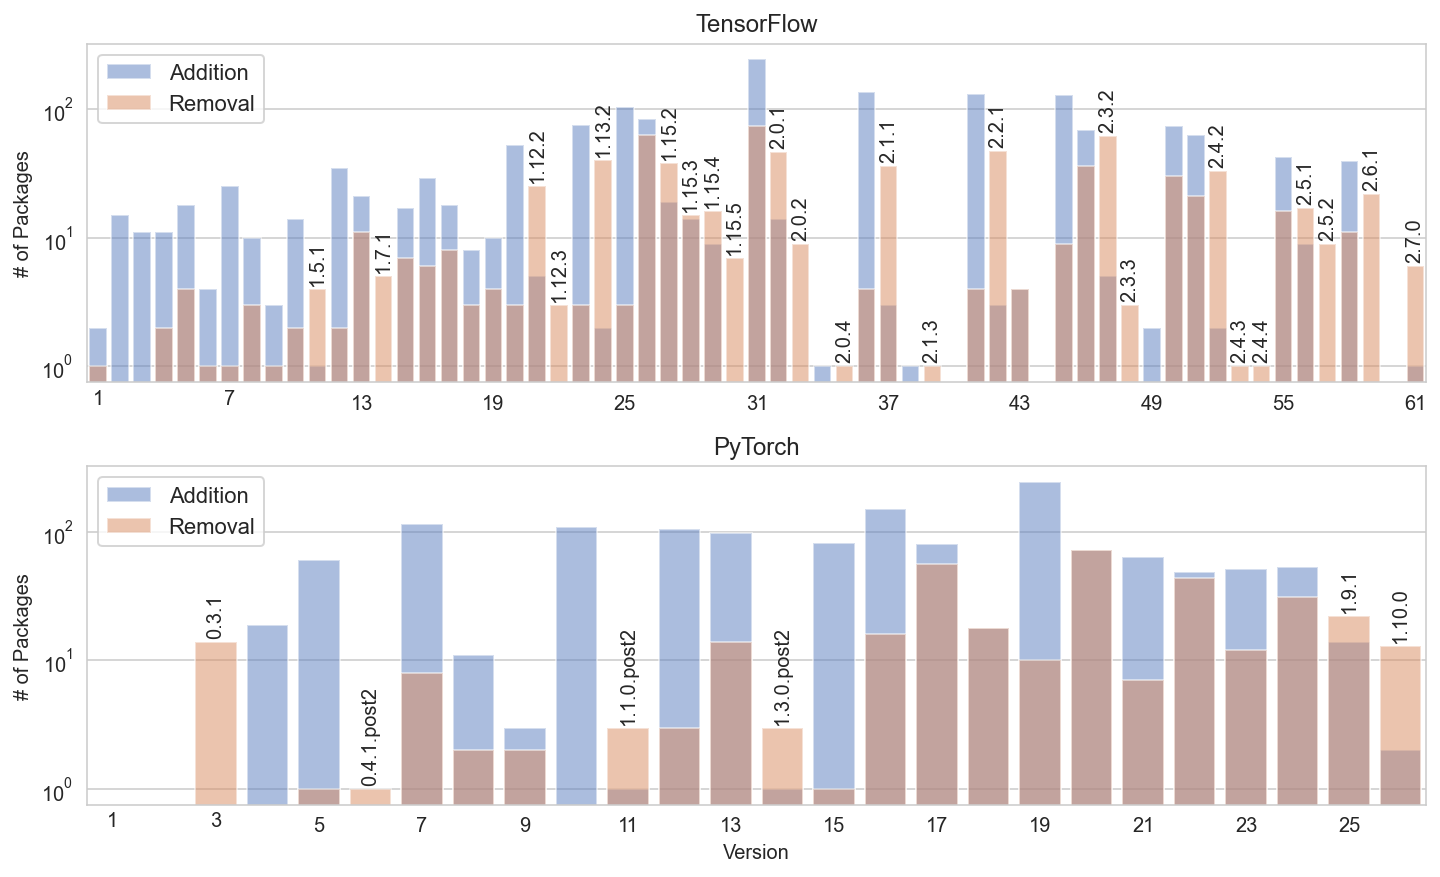

In [18]:
def plot_version_add_rmv(frmwks: list, platte='deep'):
    fig, axes = plt.subplots(len(frmwks), 1, figsize=(12, 3.5 * len(frmwks)))
    sns.set_theme(style="whitegrid")
    names = {"tensorflow": "TensorFlow", "pytorch": "PyTorch", "mxnet": "MxNet", 
             "paddlepaddle": "PaddlePaddle", "mindspore": "MindSpore"}
    #custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    if len(frmwks) == 1:
        data = add_rmv[add_rmv['Framework'].isin(frmwks)]
        ax.set_yscale("log")
        sns.histplot(data=data, x='Version', y='Addition', ax=axes, 
                     color=sns.color_palette(platte)[0], label='Addition')
        sns.histplot(data=data, x='Version', y='Removal', ax=axes, 
                     color=sns.color_palette(platte)[1], label='Removal')
        axes.set_ylabel("# of Packages")
        axes.set_xlabel(frmwks[0])
        axes.legend()
        # axes.set_xticklabels(np.arange(0, len(data['Version'])/2 + 1, (len(data['Version'])/2 + 1)/10))
    else:
        for i, f in enumerate(frmwks):
            sns.set_theme(style="whitegrid")
            data = add_rmv[add_rmv['Framework'] == f]
            data.index = list(range(1, len(data) + 1))
            axes[i].set_yscale("log")
            sns.barplot(data=data, x='Version', y='Addition', ax=axes[i], 
                        color=sns.color_palette(platte)[0], alpha=0.5, label='Addition')
            g = sns.barplot(data=data, x='Version', y='Removal', ax=axes[i], 
                        color=sns.color_palette(platte)[1], alpha=0.5, label='Removal')
            ticks = list(data[data['Removal'] > data['Addition']]['Version'].index)
            for t in ticks:
                # print(t, data.loc[t]['Removal'], data.loc[t]['Version'])
                axes[i].text(t - 1, data.loc[t]['Removal']*1.15, data.loc[t]['Version'], 
                             rotation=90, ha='center', fontsize='small')
            
            axes[i].set_xticks(np.arange(0, len(data), (len(data)) // 10))
            axes[i].set_xticklabels(np.arange(1, len(data) + 1, (len(data) + 1) // 10), 
                                    rotation=0, horizontalalignment='center')
            axes[i].tick_params(axis='x', which='major', pad=0) 
            axes[i].set_ylabel("# of Packages")
            axes[i].set_title(names[f])
            axes[i].legend(loc='upper left')
            if i < len(frmwks) - 1:
                axes[i].xaxis.label.set_visible(False)
            else:
                axes[i].set_xlabel("Version")
    fig.subplots_adjust(hspace=0.25)
    fig.savefig("figures/version_addition_removal.pdf", bbox_inches="tight")

plot_version_add_rmv(['tensorflow', 'pytorch'], 'muted')

In [19]:
def version_pkg_cnt(frmwks: list):
    res = {}
    for f in frmwks:
        res[f] = dict()
        for ver, sc in ver_scs[f].items():
            a = set()
            for l, p in sc.items():
                a = a.union(p)
            res[f][ver] = len(a)
    return res
ver_cnt = version_pkg_cnt(['tensorflow', 'pytorch', 'mxnet', 'paddlepaddle', 'mindspore'])

In [20]:
for k in ver_cnt.keys():
    tmp = sorted(ver_cnt[k].items(), key=lambda x: Version(x[0]))
    ver_cnt[k] = {k: v for k, v in tmp}

In [21]:
overall_cnt = {
    "tensorflow": 2568,
    "pytorch": 3278,
    "mxnet": 87,
    "paddlepaddle": 33,
    "mindspore": 6
}

In [24]:
list(ver_cnt['tensorflow'].keys())[31]

'2.0.0'

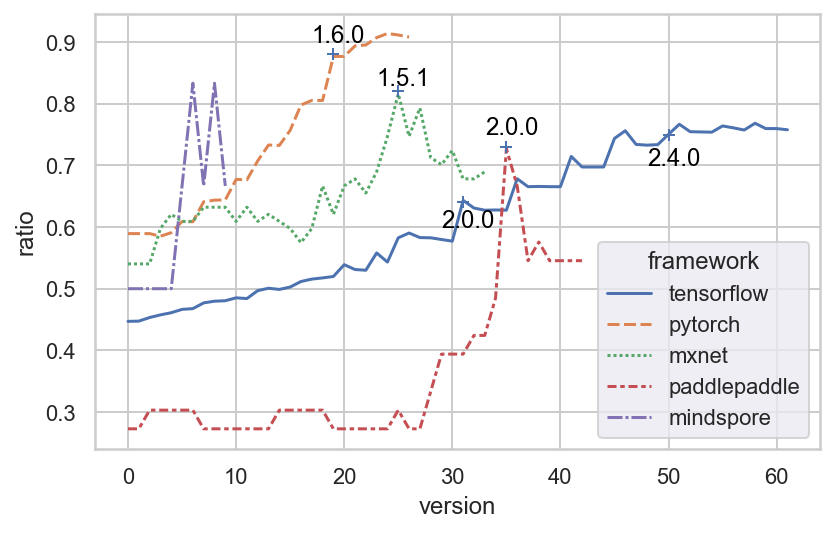

In [22]:
def plot_ratio_per_version():
    df = pd.DataFrame()
    for k, v in ver_cnt.items():
        df = pd.concat([df, pd.DataFrame({'ratio': np.array(list(v.values()))/ overall_cnt[k], 'framework': k, 
                                          'version': list(range(len(v)))})], ignore_index=True)
    f, ax = plt.subplots(figsize=(6.5, 4))
    sns.set_theme()
    sns.lineplot(data=df, x='version', y='ratio', hue='framework', style='framework', ax=ax)
    ax.plot(31, 0.64, 'b+')
    ax.annotate("2.0.0", xy=(29, 0.6), color='black')
    ax.plot(50, 0.75, 'b+')
    ax.annotate("2.4.0", xy=(48, 0.7), color='black')
    ax.plot(25, 0.82, 'b+')
    ax.annotate("1.5.1", xy=(23, 0.83), color='black')
    ax.plot(35, 0.73, 'b+')
    ax.annotate("2.0.0", xy=(33, 0.75), color='black')
    ax.plot(19, 0.88, 'b+')
    ax.annotate("1.6.0", xy=(17, 0.90), color='black')
    f.savefig("figures/ratio_per_version.pdf", bbox_inches="tight")

plot_ratio_per_version()

In [25]:
pkg_layer_cnt = {
    "tensorflow": {
        1: 3,
        2: 2218,
        3: 677,
        4: 82,
        5: 11,
        6: 1
    },
    "pytorch": {
        1: 1,
        2: 2779,
        3: 1809,
        4: 105,
        5: 12
    },
    "mxnet": {
        1: 16,
        2: 57,
        3: 17
    },
    "paddlepaddle": {
        1: 2,
        2: 30,
        3: 6
    },
    "mindspore": {
        1: 3,
        2: 3
    }
}
def ratio_over_time(intervals: float, frmwk: str):
    res = dict()
    for i in range(len(intervals)):
        res[i + 1] = dict()
        for l in pkg_layer_cnt[frmwk].keys():
            res[i + 1][l] = []
    for row in versioned_df[versioned_df['framework'] == frmwk][['name', 'version', 'layer']].iterrows():
        name, version, layer = row[1]
        if name in ['tensorflow', 'tensorflow-gpu']:
            continue
        curr_ts = pkg_ver_time[name][version]
        for i, endtime in enumerate(intervals):
            if curr_ts <= endtime:
                res[i + 1][layer].append(name)
    tmp = pd.DataFrame()
    for i in res.keys():
        for l, c in res[i].items():
            res[i][l] = len(set(c)) / pkg_layer_cnt[frmwk][l]
        tmp = tmp.append(pd.DataFrame({'ratio': list(res[i].values()), 'layer': list(res[i].keys()), 'interval': i}), ignore_index=True)
    return tmp

In [26]:
def frmwk_ratio_over_time(frmwk):
    if frmwk == 'pytorch':
        upload_times = list(retrieve_ordered_versions('torch').values())
    else:
        upload_times = list(retrieve_ordered_versions(frmwk).values())
    maxi, mini = max(upload_times), min(upload_times)
    interval = 3600 * 24 * 182.5
    interval_cnt = int(np.ceil((maxi - mini) / interval))
    intervals = []
    for i in range(1, interval_cnt + 1):
        intervals.append(mini + interval * i)
    return ratio_over_time(intervals, frmwk)

In [27]:
def plot_ratio_over_time(frmwk):
    ratio_time = frmwk_ratio_over_time(frmwk)
    f, ax = plt.subplots(figsize=(6.5, 4))
    sns.set_theme()
    sns.lineplot(data=ratio_time[ratio_time['layer'].isin([2, 3, 4, 5])], x='interval', y='ratio', hue='layer', style='layer', ax=ax)
    f.savefig(f"figures/{frmwk}_ratio__over_time.pdf", bbox_inches="tight")
    return ratio_time


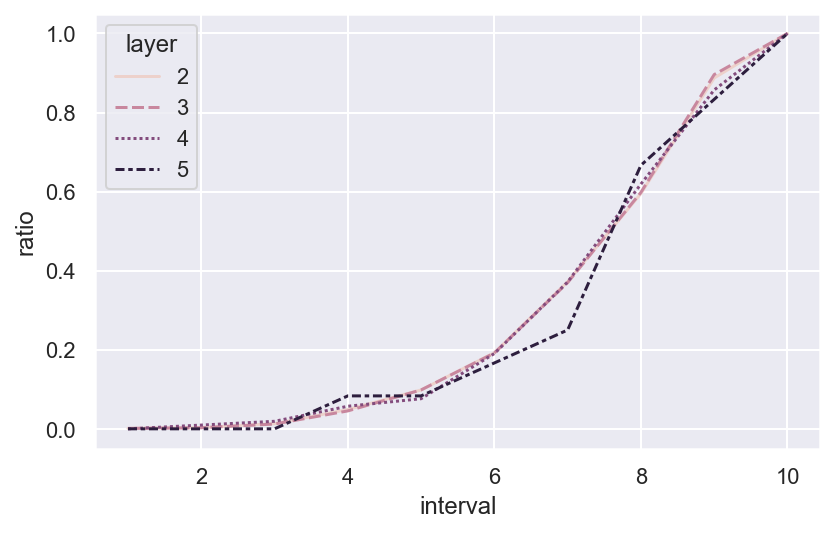

In [28]:
torch_ratio_time = plot_ratio_over_time('pytorch')

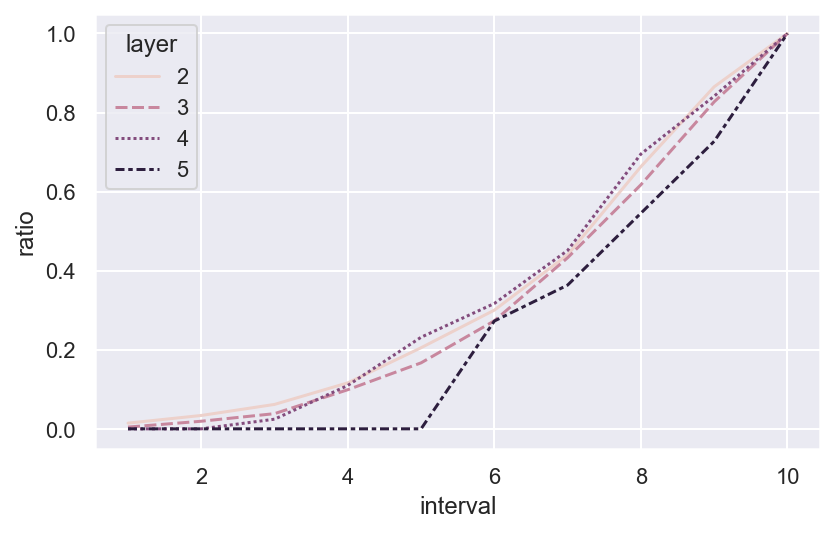

In [29]:
tf_ratio_time = plot_ratio_over_time('tensorflow')

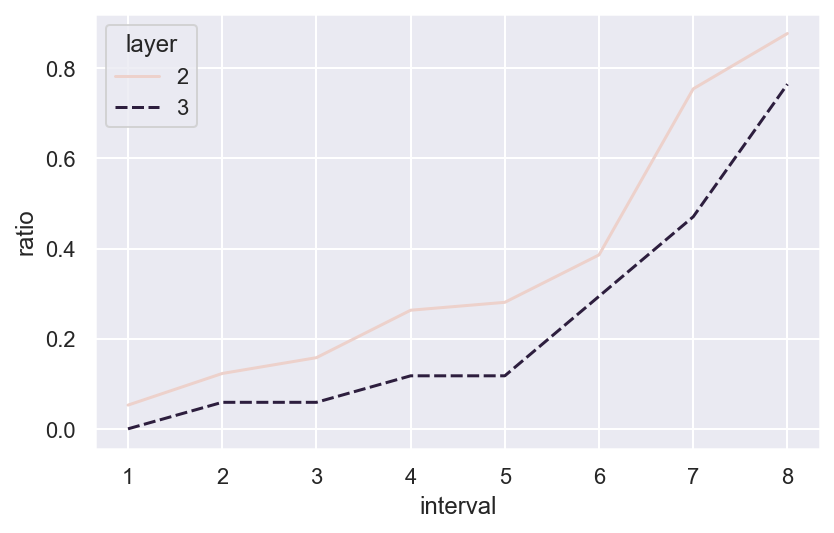

In [30]:
mxnet_ratio_time = plot_ratio_over_time('mxnet')

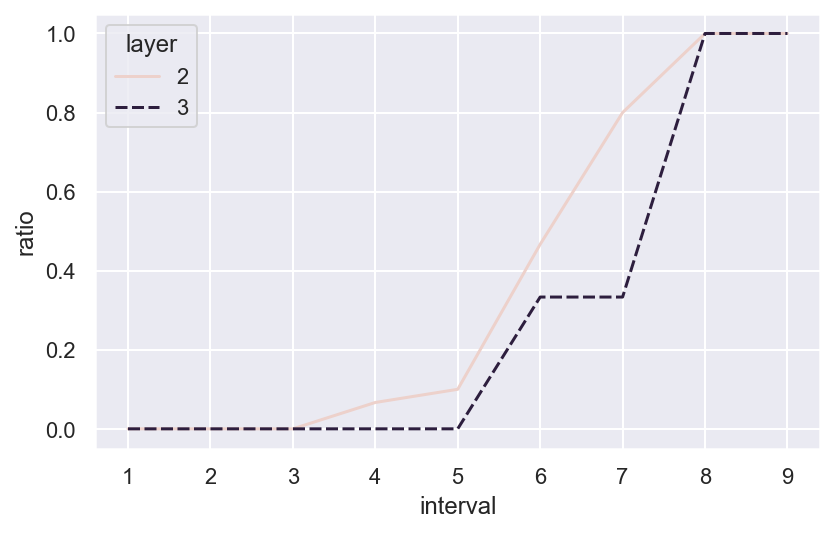

In [31]:
pp_ratio_time = plot_ratio_over_time('paddlepaddle')

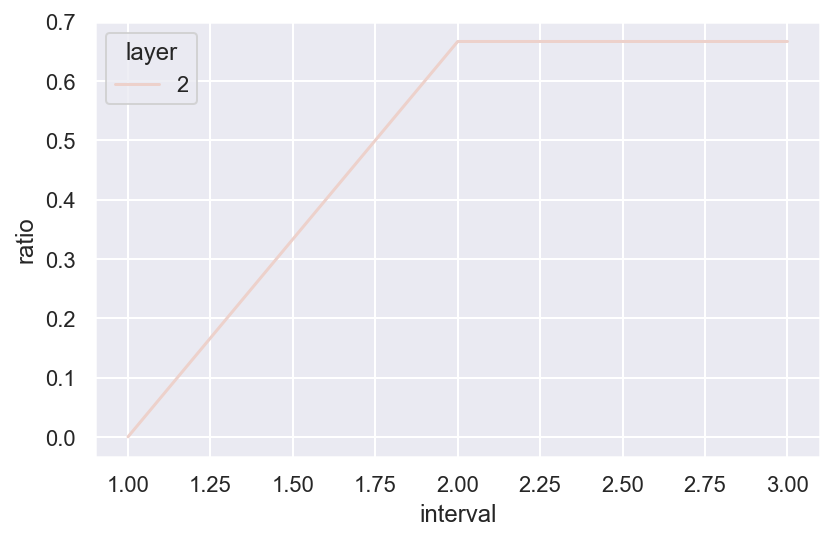

In [32]:
ms_ratio_time = plot_ratio_over_time('mindspore')